# **NLP Standard Project**
## **Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:**
### Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [1]:
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
import itertools

#bert model
import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import cuda

#metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# *DATA LOADING*

### Loading the JSON into a Pandas Dataframe and taking a first look to its structure:

In [4]:
#file_path_train = '/kaggle/input/dataset/MELD_train_efr.json'
file_path_train = '/kaggle/input/dataset-1/MELD_train_efr.json'
#file_path_train = './Data/Task C/MELD_train_efr.json'
df = pd.read_json(file_path_train)

df.shape

(4000, 5)

In [5]:
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


# *PRE-PROCESSING*

## NaN values:
### Some trigger labels are not correctly formatted and appear as NaN values, so we convert them to 0 values to avoid errors.

In [6]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [7]:
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [8]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


## Splitting of data
### We use a 80/10/10 train/val/test split, as explicitly required by the prooject description:

In [9]:
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 5)
Test shape: (400, 5)
Val shape: (400, 5)


### We observe the fact that a common dialogue is present both at at the end of training set and at the beginning of validation set. We decide to slightly refine the sizes of data, in such a way to keep the dialogue only in one of the two sets:

In [129]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [130]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [131]:
print(f"The dialogue continues until utterance 3205:")
print(f"Dialogue: {df_test['utterances'][3205]}")

The dialogue continues until utterance 3205:
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this pear.", 

In [132]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [133]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


In [10]:
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (397, 5)
Val shape: (398, 5)


### We make a similar observation printing the last utterance of validation set and the first one of test set:

In [135]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [136]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [137]:
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [138]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3602]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [139]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


### The final shape of data is the following:

In [11]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (397, 5)
Val shape: (398, 5)


## Splitting of every sentence in the DataFrames' dialogues

In [12]:
def split_utterances(df):
    speakers_list = []
    utterances_list = []
    emotions_list = []
    trigger_list = []

    #Itera su ogni riga del dataframe originale
    for index, row in df.iterrows():
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']

        # Itera su ogni frase nell'array 'utterances'
        for i in range(len(utterances)):
            speakers_list.append(speakers[i])
            utterances_list.append(utterances[i])
            emotions_list.append(emotions[i])
            trigger_list.append(triggers[i])

    # Crea un nuovo dataframe dalle liste
    new_df = pd.DataFrame({
        'speaker': speakers_list,
        'utterance': utterances_list,
        'emotion': emotions_list,
        'trigger': trigger_list
    })

    return new_df

In [13]:
# Splitting of sentences in the training set
df_train_s = split_utterances(df_train)
df_train_s.head(15)

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0
5,Chandler,also I was the point person on my company's tr...,neutral,0.0
6,The Interviewer,You must've had your hands full.,neutral,0.0
7,Chandler,That I did. That I did.,neutral,0.0
8,The Interviewer,So let's talk a little bit about your duties.,neutral,0.0
9,Chandler,My duties? All right.,surprise,0.0


In [14]:
# Taking a look to the new structure of the training set
print(df_train_s.iloc[52:69,:])

     speaker                                          utterance   emotion  \
52  Chandler                                          Hey, Mon.   neutral   
53    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
54  Chandler                                         Do I ever.       joy   
55  Chandler                                          Hey, Mon.   neutral   
56    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
57  Chandler                                         Do I ever.       joy   
58    Monica           Chris says they're closing down the bar.   sadness   
59  Chandler                                          Hey, Mon.   neutral   
60    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
61  Chandler                                         Do I ever.       joy   
62    Monica           Chris says they're closing down the bar.   sadness   
63  Chandler                                            No way!  surprise   

In [15]:
# Splitting of all the sentences in the remaining sets
df_test_s = split_utterances(df_test)

df_val_s = split_utterances(df_val)

## *DATA EXPLORATION*
### Is the train dataset imbalanced? We verify this hypothesis both for 'emotions' and 'triggers' labels:

### Emotions distribution:

In [16]:
emotions_counts = {}
for emotions in df_train['emotions']:
    for emotion in emotions:
        if emotion in emotions_counts:
            emotions_counts[emotion] += 1
        else:
            emotions_counts[emotion] = 1

print(emotions_counts)

{'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}


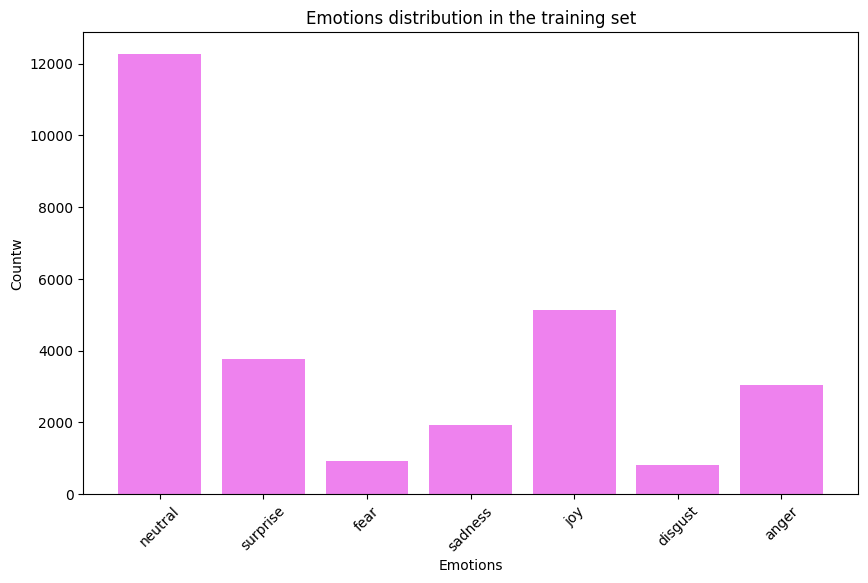

In [17]:
emotions = list(emotions_counts.keys())
emotion_counts = list(emotions_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='violet')
plt.xlabel('Emotions')
plt.ylabel('Countw')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

### Triggers distribution:

In [18]:
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


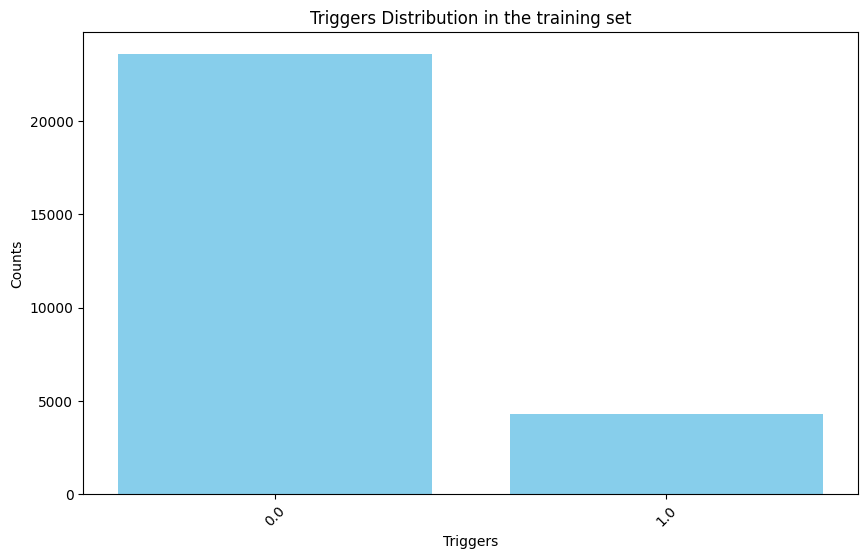

In [19]:
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color='skyblue')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

In [20]:
# Calculating classes' weights
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts) * count) for emotion, count in emotions_counts.items()}

print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


### As we can see both emotions and triggers are highly imbalanced, the emotion with the highest count is 'neutral' and the trigger with the highest count is '0.0'.

### When a class imbalance exists within the training data, machine learning models will typically over-classify the larger classes due to their increased prior probability. As a result, the instances belonging to the smaller class(es) are typically misclassified more often than those belonging to the larger class(es).
### How to deal with imbalanced data in classification? https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

### We choose Class Weighting for dealing with this imbalance:

In [21]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

# Calculate weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

# Save the weights in a dictionary 
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


### Class weights computing using sklearn class_weight='balanced'

In [22]:
# Calculate triggers' weights
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## *MODELS DEFINITION*

### As explicitly requested, we should train and evaluate a BERT baseline on two different settings:
####    1. Freezed: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
####    2. Full: we fine-tune the whole model architecture.
     
### In addition, we should evaluate a random and a majority classifier for emotions and triggers.

### Baseline models
#### Defining random and majority dummy classifiers

In [23]:
random_emotions = DummyClassifier(strategy='uniform', random_state = 42)
majority_emotions = DummyClassifier(strategy='most_frequent')

random_triggers = DummyClassifier(strategy='uniform', random_state = 42)
majority_triggers = DummyClassifier(strategy='most_frequent')

In [24]:
# Look again at the structure of the DataFrame
df_train_s.head()

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0


In [25]:
# Isolate labels for training set
X_train = df_train_s.drop(columns=['emotion', 'trigger'])

y_train_emotions = df_train_s['emotion']
y_train_triggers = df_train_s['trigger']

In [26]:
# Isolate labels for test set
X_test = df_test_s.drop(columns=['emotion', 'trigger'])

y_test_emotions = df_test_s['emotion']
y_test_triggers = df_test_s['trigger']

In [27]:
# Fit the emotions' dummy classifiers
random_emotions.fit(X_train, y_train_emotions)
majority_emotions.fit(X_train, y_train_emotions)

# Fit the triggers' dummy classifiers
random_triggers.fit(X_train, y_train_triggers)
majority_triggers.fit(X_train, y_train_triggers)

DummyClassifier(strategy='most_frequent')

#### Evaluating baseline models

In [28]:
# Evaluate emotions' dummy classifiers on test set
y_pred_random_emotions = random_emotions.predict(X_test)
y_pred_majority_emotions = majority_emotions.predict(X_test)

# Evaluate triggers' dummy classifiers on test set
y_pred_random_triggers = random_triggers.predict(X_test)
y_pred_majority_triggers = majority_triggers.predict(X_test)

In [29]:
# Printing classification reports

# For emotions
print("Classification report for baseline random clf emotions:")
print(classification_report(y_test_emotions, y_pred_random_emotions, zero_division=0))

print("Classification report for baseline majority clf emotions:")
print(classification_report(y_test_emotions, y_pred_majority_emotions, zero_division=0))

# For triggers
print("Classification report for baseline random clf triggers:")
print(classification_report(y_test_triggers, y_pred_random_triggers, zero_division=0))

print("Classification report for baseline majority clf triggers:")
print(classification_report(y_test_triggers, y_pred_majority_triggers, zero_division=0))

Classification report for baseline random clf emotions:
              precision    recall  f1-score   support

       anger       0.15      0.16      0.15       455
     disgust       0.03      0.17      0.05        88
        fear       0.03      0.12      0.05       121
         joy       0.16      0.14      0.15       574
     neutral       0.39      0.14      0.20      1493
     sadness       0.10      0.14      0.11       349
    surprise       0.12      0.14      0.13       438

    accuracy                           0.14      3518
   macro avg       0.14      0.14      0.12      3518
weighted avg       0.24      0.14      0.16      3518

Classification report for baseline majority clf emotions:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       455
     disgust       0.00      0.00      0.00        88
        fear       0.00      0.00      0.00       121
         joy       0.00      0.00      0.00       574
     neutral      

### Metrics definition

Ho interpretato le due metriche così:

1. SEQUENCE F1-SCORE - per ogni istanza calcola l'F1-score fra l'array di labels predetto dal modello e l'array cdi true labels (sia per Triggers che per Emotions); poi computa il valor medio fra le istanze del DataFrame;
2. UNROLLED F1-SCORE - opera un flatten di tutte le utterances, che vengono considerate come se facessero parte di un singolo dialogo: viene poi calcolato l'F1-score considerando l'array di tutte le labels predette dal modello per tutte le utterances facenti parte del DataFrame e l'array di tutte le true labels relative a tutte le utterances del DataFrame.

In [159]:
def compute_metrics(df_with_predictions):
    """
        Compute sequence and unrolled F1-scores for Triggers and Emotions for each dialogue in the DataFrame.

        Input:
            df_with_predictions: DataFrame containing the following columns:
            - 'triggers': list of lists of ground truth trigger labels for each dialogue
            - 'Predicted_Triggers': list of lists of predicted trigger labels for each dialogue
            - 'emotions': list of lists of ground truth emotion labels for each dialogue
            - 'Predicted_Emotions': list of lists of predicted emotion labels for each dialogue

        Output:
            Dictionary containing the following metrics:
            - 'avg_sequence_f1_triggers': average F1-score for Triggers computed at the dialogue level
            - 'avg_sequence_f1_emotions': average F1-score for Emotions computed at the dialogue level
            - 'unrolled_f1_triggers': F1-score for Triggers computed at the utterance level
            - 'unrolled_f1_emotions': F1-score for Emotions computed at the utterance level
    """
    # Initialize lists to store F1-scores for each dialogue
    sequence_f1_scores_triggers = []
    sequence_f1_scores_emotions = []

    # Iterate over each dialogue (instance)
    for _, row in df_with_predictions.iterrows():
        # Compute F1-score for Triggers
        f1_triggers = f1_score(row['triggers'], row['Predicted_Triggers'], average='macro')
        sequence_f1_scores_triggers.append(f1_triggers)

        # Compute F1-score for Emotions
        f1_emotions = f1_score(row['emotions'], row['Predicted_Emotions'], average='macro', labels=list(set(row['emotions'])))
        sequence_f1_scores_emotions.append(f1_emotions)

    # Compute average F1-score for each dialogue
    avg_sequence_f1_triggers = sum(sequence_f1_scores_triggers) / len(sequence_f1_scores_triggers)
    avg_sequence_f1_emotions = sum(sequence_f1_scores_emotions) / len(sequence_f1_scores_emotions)

    # Flatten all utterances
    all_true_triggers = [trigger for row in df['triggers'] for trigger in row]
    all_predicted_triggers = [trigger for row in df['Predicted_Triggers'] for trigger in row]
    all_true_emotions = [emotion for row in df['emotions'] for emotion in row]
    all_predicted_emotions = [emotion for row in df['Predicted_Emotions'] for emotion in row]

    # Compute F1-score for flattened utterances
    unrolled_f1_triggers = f1_score(all_true_triggers, all_predicted_triggers, average='macro')
    unrolled_f1_emotions = f1_score(all_true_emotions, all_predicted_emotions, average='macro', labels=list(set(all_true_emotions)))

    return {
        'avg_sequence_f1_triggers': avg_sequence_f1_triggers,
        'avg_sequence_f1_emotions': avg_sequence_f1_emotions,
        'unrolled_f1_triggers': unrolled_f1_triggers,
        'unrolled_f1_emotions': unrolled_f1_emotions
    }

### BERT-based models

#### One-Hot-Encoding

In [30]:
# Define an encoding dictionary for emotions label
emotions_encoded_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [31]:
# Define an encoding dictionary for triggers label
triggers_encoded_dict = {
    0: [1, 0],
    1: [0, 1]
}

#### Data exploration: we want to correctly define the max_length parameter for tokenization

   word_length
0           16
1           16
2           17
3           26
4           11


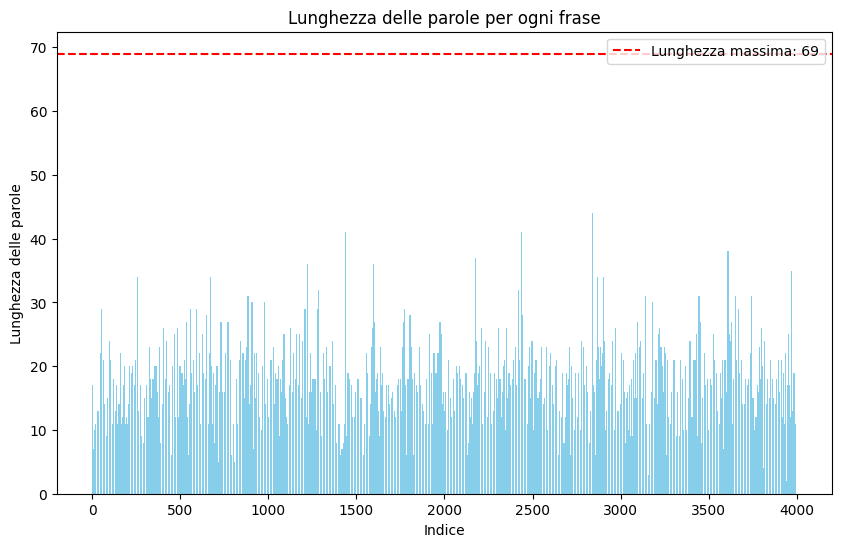

In [32]:
# Calculate the length of every word for every row in 'utterances'
df_length = pd.DataFrame()
df_length['word_length'] = df['utterances'].apply(lambda arr: max(len(x.split()) for x in arr))

print(df_length.head())

# Calculate the maximum length over all rows
max_length = df_length['word_length'].max()


# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_length.index, df_length['word_length'], color='skyblue')
plt.axhline(y=max_length, color='r', linestyle='--', label=f'Lunghezza massima: {max_length}')
plt.xlabel('Indice')
plt.ylabel('Lunghezza delle parole')
plt.title('Lunghezza delle parole per ogni frase')
plt.legend()
plt.show()

#### We can see that the maximum number of words in a dialogue is 263, so if we consider it as the MAX_LENGTH value for the padding process we would cover all the utterances.

max length: 263
max length id: 3901


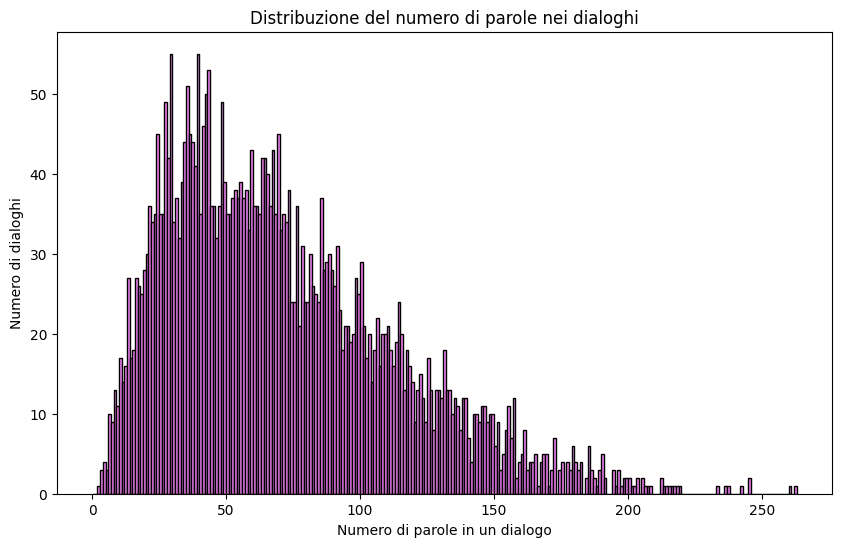

In [34]:
# Calculate the length of each word for every row in 'utterances' column
df_length = pd.DataFrame()
df_length['total_word_length'] = df['utterances'].apply(lambda arr: sum(len(x.split()) for x in arr))

# Calculate the maximum length over all the rows
max_length = df_length['total_word_length'].max()
print(f"max length: {max_length}")

# Get the id of the longest dialogue
max_length_id = df_length['total_word_length'].idxmax()
print(f"max length id: {max_length_id}")


# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(df_length['total_word_length'], bins=range(0, df_length['total_word_length'].max() + 1, 1), color='violet', edgecolor='black')
plt.xlabel('Numero di parole in un dialogo')
plt.ylabel('Numero di dialoghi')
plt.title('Distribuzione del numero di parole nei dialoghi')
plt.show()

#### We also show also the boxplot of the distribution to check for outliers values: as we expected, there are only fews dialogues that exceed 256. For this reason we use the nearest squared value which is 256 and not 512.

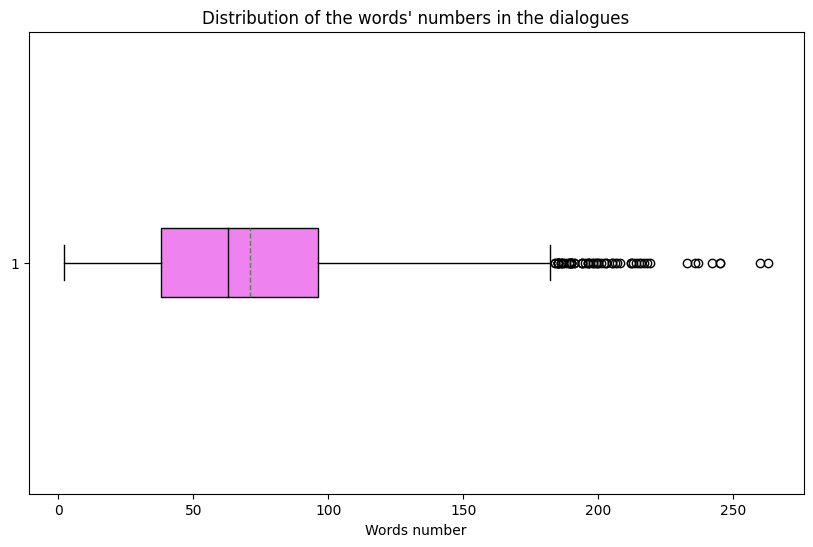

In [35]:
# Box-plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_length['total_word_length'], vert=False, patch_artist=True, boxprops=dict(facecolor='violet'), 
            medianprops=dict(color='black'), meanline=True, showmeans=True)
plt.xlabel("Words number")
plt.title("Distribution of the words' numbers in the dialogues")
plt.show()

### Tokenization step

In [36]:
# Definition of tokenizer and useful hyperprameters
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 256
BATCH_SIZE = 32 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Dataset definition, as expected by BERT-based classifiers

In [38]:
# Define the Class for the tokenized Dataset for BERT
class BERTDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotions_encoded_dict = emotions_encoded_dict
        self.triggers_encoded_dict = triggers_encoded_dict
        self.data = self._create_data()
    
    # Split the Data into single sentences
    def _create_data(self):
        data = []
        for _, row in self.dataframe.iterrows():
            utterances = row["utterances"]
            emotions = row["emotions"]
            triggers = row["triggers"]
            for utterance, emotion, trigger in zip(utterances, emotions, triggers):
                data.append((utterance, emotion, trigger))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        utterance, emotion, trigger = self.data[index]
        target_emotion = self.emotions_encoded_dict[emotion]
        target_trigger = self.triggers_encoded_dict[trigger]

        encoding = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True,
        )

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        token_type_ids = encoding["token_type_ids"]
        
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_emotion": torch.tensor(target_emotion, dtype=torch.float),
            "target_trigger": torch.tensor(target_trigger, dtype=torch.float),
        }

In [70]:
import torch
from torch.utils.data import Dataset

class BERTDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotions_encoded_dict = emotions_encoded_dict
        self.triggers_encoded_dict = triggers_encoded_dict
        self.data = self._create_data()

    def _create_data(self):
        data = []
        for _, row in self.dataframe.iterrows():
            episode_data = {
                "episode": row["episode"],
                "utterances": row["utterances"],
                "emotions": row["emotions"],
                "triggers": row["triggers"]
            }
            data.append(episode_data)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        episode_data = self.data[index]
        utterances = episode_data["utterances"]
        emotions = episode_data["emotions"]
        triggers = episode_data["triggers"]

        combined_input_ids = []
        combined_attention_mask = []
        combined_token_type_ids = []

        for utterance in utterances:
            encoding = self.tokenizer.encode_plus(
                utterance,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=True,
                padding="max_length",
                truncation=True,
            )

            combined_input_ids.extend(encoding["input_ids"])
            combined_attention_mask.extend(encoding["attention_mask"])
            combined_token_type_ids.extend(encoding["token_type_ids"])

        target_emotions = [self.emotions_encoded_dict[emotion] for emotion in emotions]
        target_triggers = [self.triggers_encoded_dict[trigger] for trigger in triggers]

        return {
            "input_ids": torch.tensor(combined_input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(combined_attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(combined_token_type_ids, dtype=torch.long),
            "target_emotions": torch.tensor(target_emotions, dtype=torch.float),
            "target_triggers": torch.tensor(target_triggers, dtype=torch.float),
        }

In [71]:
# Create Datasets from training, validation and test DataFrames
bert_train_dataset = BERTDataset(df_train, tokenizer, MAX_LENGTH)
bert_test_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)
bert_val_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)

# Data-loading step
train_loader= DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True) #ricontrollare se shuffle deve essere true o false
test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [78]:
print(f"shape bert dataset {len(train_loader)}")

shape bert dataset 101


In [84]:
print(train_loader.dataset[0])

{'input_ids': tensor([ 101, 2036, 1045,  ...,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'token_type_ids': tensor([0, 0, 0,  ..., 0, 0, 0]), 'target_emotions': tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]]), 'target_triggers': tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])}


In [ ]:
# Print the keys in the DataLoader object
print(train_loader)

for batch in train_loader:
    print(batch.keys())
    break  # only prints the keys for the first batch, as the others have a similar structure

### BERT model definition

#### Our source was https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForPreTraining


In [86]:
# Definition of BERT model Class
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(self.l1.config.hidden_size, 7)
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3)
        self.l5 = torch.nn.Linear(self.l1.config.hidden_size, 2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return output_emotions, output_trigger

In [87]:
# Use bert-base-uncased pre-trained model
model_name = 'bert-base-uncased'

# Define full model
full_model = BERTClass(model_name)
full_model.to(device)

# Define freezed model
freezed_model = BERTClass(model_name)
freezed_model.to(device)
# Freezing of parameters for freezed model
for param in freezed_model.l1.parameters():
    param.requires_grad = False

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

### Loss function
#### 2 weighted binary cross entropy losses, whose sum is the final output of the function

In [88]:
# Convert weights into tensors
emotions_weights_tensor = torch.tensor(list(emotions_weights_dict.values()), dtype=torch.float32).to(device)
triggers_weights_tensor = torch.tensor(list(triggers_weights_dict.values()), dtype=torch.float32).to(device)

def weighted_binary_cross_entropy_loss(emotion_output, true_emotions, trigger_output, true_triggers, emotions_weights_tensor, triggers_weights_tensor):
    # Move tensors to device
    emotions_weights_tensor = emotions_weights_tensor.to(device)
    triggers_weights_tensor = triggers_weights_tensor.to(device)

    # Emotions loss function
    loss_emotions = torch.nn.BCEWithLogitsLoss(weight=emotions_weights_tensor)
    loss_e_value = loss_emotions(emotion_output, true_emotions)

    # Triggers loss function
    loss_triggers = torch.nn.BCEWithLogitsLoss(weight=triggers_weights_tensor)
    loss_t_value = loss_triggers(trigger_output, true_triggers)

    return loss_e_value + loss_t_value

### Validation function

#### This validation function on val dataset during training. It calculates loss -using the defined loss function- and accuracy; according to this calculation, it early stops training if negative performances on validation set are detected for a fixed number of consecutive epochs; the model is saved at any positive iteration.

In [89]:
# Define validation function
def validation(model, val_loader, emotions_weights_tensor, triggers_weights_tensor):
    model.eval()
    # Initaite variables for iteration
    val_loss = 0
    correct_emotion = 0
    correct_trigger = 0
    total_emotion = 0
    total_trigger = 0

    with torch.no_grad():
        # Iterate on each validation set batch
        for _, data in enumerate(val_loader, 0):
            # Move tokenization logits on device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            # Generate emotions and trigger outputs
            emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids)
            # Caluclate loss using the defined function
            val_loss += weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)

            # Compute accuracy
            predicted_emotion = torch.round(torch.sigmoid(emotion_output))
            predicted_trigger = torch.round(torch.sigmoid(trigger_output))
            correct_emotion += (predicted_emotion == target_emotion).sum().item()
            total_emotion += target_emotion.numel()  # Total number of elements in target_emotion
            correct_trigger += (predicted_trigger == target_trigger).sum().item()
            total_trigger += target_trigger.numel()  # Total number of elements in target_trigger
            
    # Calculate average loss and accuracy
    val_loss /= len(val_loader)
    accuracy_emotion = correct_emotion / total_emotion
    accuracy_trigger = correct_trigger / total_trigger

    return val_loss, accuracy_emotion, accuracy_trigger

### Function to call training and validation
#### It invokes training over a fixed number of epochs; it then calls validation function.

In [90]:
def train_model(model, train_loader, validation_loader, emotions_weights_tensor, triggers_weights_tensor, num_epochs, patience, checkpoint_path, learning_rate):
    # Initiate Adam optimizer and some useful variables for iteration
    size = len(train_loader.dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    patience_counter = 0

    # Move model to GPU
    model.to(device)
    
    # Iterate over num_epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}.')
        model.train()  # Set the model in train mode
        train_loss = 0.0
        
        # Iterate over every batch in the training set
        for batch, data in enumerate(train_loader, 0):
            # Move tokenization logits to device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            optimizer.zero_grad()

            # Generate model predictions
            emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids)

            # Compute loss using the defined function and utilizes it for updating model weights invoking the optimizer
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            loss.backward()
            optimizer.step()
            
            # Update loss counter
            train_loss += loss.item()
            
            if batch%5000==0:
              current =  batch * len(data['input_ids'])
              print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        
        # Calculate average loss over training set
        train_loss /= len(train_loader)

        # Invoke validation function
        val_loss, val_accuracy_emotion, val_accuracy_trigger = validation(model, validation_loader, emotions_weights_tensor, triggers_weights_tensor)

        # Print the computations
        print(f'Epoch {epoch+1}/{num_epochs}, Average Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy Emotion: {val_accuracy_emotion:.4f}, Val Accuracy Trigger: {val_accuracy_trigger:.4f}')

        # Manage early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break
        print('\n')
        
print('\n')

#### Now we move to searching for the best configuration for hyperparameters.
#### We want to find the best possible trade-off between the optimization of the performances of the two models: that's why we opt for average accuracy between the two.

#### The code used for this search is the following:

In [ ]:
# Define the hyperparameter grid

hyperparameter_grid = {
    'seeds': [42, 123, 200, 322, 506],
    'epochs': [3, 5],
    'learning_rate': [1e-5, 5e-5],
    'patience': [2, 5]
}


# Function to train and evaluate both models
def train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience):
    
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    
    # Train the full model
    train_model(full_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, full_model_checkpoint_path, learning_rate)
    
    
    # Evaluate the full model
    _, accuracy_emotion_full, accuracy_trigger_full = validation(full_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Train the freezed model
    train_model(freezed_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, freezed_model_checkpoint_path, learning_rate)
    
    # Evaluate the freezed model
    _, accuracy_emotion_freezed, accuracy_trigger_freezed = validation(freezed_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Calculate the average accuracy for both models
    average_accuracy = (accuracy_emotion_full + accuracy_trigger_full + accuracy_emotion_freezed + accuracy_trigger_freezed) / 4
    
    return average_accuracy


# Initialize variables to track the best hyperparameters
best_average_accuracy = 0
best_hyperparameters = None

# Paths to the pre-trained model checkpoints
full_model_checkpoint_path = 'full_best_model.pth'
freezed_model_checkpoint_path = 'freezed_best_model.pth'

# Iterate over all combinations of hyperparameters
for seed, epochs, learning_rate, patience in itertools.product(
        hyperparameter_grid['seeds'],
        hyperparameter_grid['epochs'],
        hyperparameter_grid['learning_rate'],
        hyperparameter_grid['patience']):
    
    # Train and evaluate both models
    average_accuracy = train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience)
    
    # Update the best hyperparameters if the current combination is better
    if average_accuracy > best_average_accuracy:
        best_average_accuracy = average_accuracy
        best_hyperparameters = {
            'seed': seed,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'patience': patience
        }

print(f'Best Average Accuracy: {best_average_accuracy}')
print(f'Best Hyperparameters: {best_hyperparameters}')

#### The best configuration found shows an average_accuracy = 0.865597830421951.

#### We now train and evaluate both models using the selected hyperparameters:

In [92]:
# Define the best configuration of hyperparameters
seed = 42
epochs = 5
learning_rate = 5e-5
patience = 2 

# Set the seed for reproducibility
torch.manual_seed(seed);

#### Training of full model

In [93]:
# Invoke training function for full model
train_model(full_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'full_best_model.pth', learning_rate)

print("Training completed for full model!")

Epoch 1/5.


RuntimeError: stack expects each tensor to be equal size, but got [4352] at entry 0 and [1792] at entry 1

#### Training of freezed model

In [ ]:
# Invoke training function for freezed model
train_model(freezed_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'freezed_best_model.pth', learning_rate)

print("Training completed for freezed model!")

### Evaluation function

#### It performs the evaluation step over test set

In [ ]:
def evaluation(model, test_loader, emotions_weights_tensor, triggers_weights_tensor):
    model.eval()  # Set the model in evaluation mode
    # Initiate useful variables for iteration
    test_loss = 0.0
    all_emotion_outputs = []
    all_trigger_outputs = []
    all_target_emotions = []
    all_target_triggers = []

    with torch.no_grad():  
        # Iterate over every batch in test set
        for data in test_loader:
            # Move tokenization logits in device
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)

            # Model predictions
            emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids)

            # Calculate loss
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            test_loss += loss.item()

            # Save outputs and targets
            all_emotion_outputs.append(emotion_output.cpu())
            all_trigger_outputs.append(trigger_output.cpu())
            all_target_emotions.append(target_emotion.cpu())
            all_target_triggers.append(target_trigger.cpu())
    
    # Calculate average test loss
    test_loss /= len(test_loader)

    # Concatenate all outputs and targets
    all_emotion_outputs = torch.cat(all_emotion_outputs, dim=0)
    all_trigger_outputs = torch.cat(all_trigger_outputs, dim=0)
    all_target_emotions = torch.cat(all_target_emotions, dim=0)
    all_target_triggers = torch.cat(all_target_triggers, dim=0)

    print(f'Test Loss: {test_loss:.4f}')

    return all_emotion_outputs, all_trigger_outputs, all_target_emotions, all_target_triggers

#### Evaluation of full model

In [ ]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'full_best_model.pth'
full_model.load_state_dict(torch.load(checkpoint_path))

# Invoke evaluation function for full model
all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full = evaluation(full_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

In [ ]:
# Take a look to outputs
print(all_emotion_outputs_full) 
print(all_trigger_outputs_full)

In [ ]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'freezed_best_model.pth'
freezed_model.load_state_dict(torch.load(checkpoint_path))
# Invoke evaluation function for freezed model
all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed= evaluation(freezed_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

In [ ]:
# Take a look to outputs
print(all_emotion_outputs_freezed) 
print(all_trigger_outputs_freezed) 

#### Defining a DataFrame with predictions and targets

In [ ]:
def tensor_to_dataframe(emotion_outputs, trigger_outputs, target_emotions, target_triggers):
    data = {
        'predicted_emotions': [output for output in emotion_outputs], # Predicitions are kept in logits form
        'predicted_triggers': [output for output in trigger_outputs],
        'target_emotions': [target.tolist() for target in target_emotions], # Targets are converted to lists
        'target_triggers': [target.tolist() for target in target_triggers]
    }
    # Convert into a DataFrame
    df = pd.DataFrame(data)
    return df

# Invoke the function on the targets and on the predictions of the two models
results_df_full = tensor_to_dataframe(all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full) 
results_df_freezed = tensor_to_dataframe(all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed)

In [ ]:
# Take a look to the structure of one of the defined DataFrames
print(results_df_full.head())

#### We now plot some preliminar results on the two models: the following functions decode the labels and plots  classification reports and heatmaps of correlation matrices

In [ ]:
# Function to convert tensors to one-hot encoded arrays
def convert_to_one_hot(tensor_array):
    one_hot_array = np.zeros_like(tensor_array)
    one_hot_array[tensor_array.argmax(0)] = 1
    return one_hot_array

# Functions to decode one-hot encoded arrays to labels
def decode_emotions(one_hot_array, emotions_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in emotions_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

def decode_triggers(one_hot_array, triggers_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in triggers_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

# Function to process the DataFrame
def process_dataframe(df, emotions_encoded_dict, triggers_encoded_dict):
    # Convert tensors to one-hot encoded arrays
    df['predicted_emotions'] = df['predicted_emotions'].apply(lambda x: convert_to_one_hot(np.array(x)))
    df['predicted_triggers'] = df['predicted_triggers'].apply(lambda x: convert_to_one_hot(np.array(x)))
    
    # Decode one-hot encoded arrays to labels
    df['predicted_emotions_decoded'] = decode_emotions(df['predicted_emotions'], emotions_encoded_dict)
    df['target_emotions_decoded'] = decode_emotions(df['target_emotions'], emotions_encoded_dict)
    df['predicted_triggers_decoded'] = decode_triggers(df['predicted_triggers'], triggers_encoded_dict)
    df['target_triggers_decoded'] = decode_triggers(df['target_triggers'], triggers_encoded_dict)
    
    return df

# Function to calculate correlation matrices and classification reports
def calculate_metrics(df):
    # Generate correlation matrices
    emotions_corr_matrix = pd.crosstab(df['predicted_emotions_decoded'], df['target_emotions_decoded'])
    triggers_corr_matrix = pd.crosstab(df['predicted_triggers_decoded'], df['target_triggers_decoded'])
    # Generate classification reports
    emotions_classification_report = classification_report(df['target_emotions_decoded'], df['predicted_emotions_decoded'])
    triggers_classification_report = classification_report(df['target_triggers_decoded'], df['predicted_triggers_decoded'])
    
    return emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report

# Function to plot heatmaps
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.show()

#### Heatmaps for full model

In [ ]:
# Decoding the labels
results_df_full = process_dataframe(results_df_full, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_full)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for full model

In [ ]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

#### Heatmaps for freezed model

In [ ]:
# Decoding the labels
results_df_freezed = process_dataframe(results_df_freezed, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_freezed)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for freezed model

In [ ]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

### Evaluation Metrics Definition

#### Definition of Unrolled F1 score for the two models: the function computes the per-category and average F1 score for each row; then, an average is computed over all the rows.

In [ ]:
# Function to calculate unrolled F1-score
def calculate_unrolled_f1_score(df):
    f1_scores_emotions = []
    f1_scores_triggers = []
    
    for _, row in df.iterrows():
        f1_emotions = f1_score([row['target_emotions_decoded']], [row['predicted_emotions_decoded']], average=None)
        f1_triggers = f1_score([row['target_triggers_decoded']], [row['predicted_triggers_decoded']], average=None)
        
        f1_scores_emotions.append(f1_emotions)
        f1_scores_triggers.append(f1_triggers)
    
    # Convert lists to numpy arrays for easier manipulation
    f1_scores_emotions = np.array(f1_scores_emotions)
    f1_scores_triggers = np.array(f1_scores_triggers)
    
    # Calculate per-category F1 scores
    avg_f1_emotions_per_category = np.mean(f1_scores_emotions, axis=0)
    avg_f1_triggers_per_category = np.mean(f1_scores_triggers, axis=0)
    
    # Calculate full-average F1 scores
    avg_f1_emotions = np.mean(avg_f1_emotions_per_category)
    avg_f1_triggers = np.mean(avg_f1_triggers_per_category)
    
    return avg_f1_emotions_per_category, avg_f1_triggers_per_category, avg_f1_emotions, avg_f1_triggers


#### Computation of Unrolled F1 score for the two models

In [ ]:
# Calculate F1 score for the two models
avg_f1_emotions_per_category_full, avg_f1_triggers_per_category_full, avg_f1_emotions_full, avg_f1_triggers_full = calculate_unrolled_f1_score(results_df_full)
avg_f1_emotions_per_category_freezed, avg_f1_triggers_per_category_freezed, avg_f1_emotions_freezed, avg_f1_triggers_freezed = calculate_unrolled_f1_score(results_df_freezed)

# Print the obtained scores
print('FULL MODEL:')
print("Unrolled F1 Score per Category for Emotions:", avg_f1_emotions_per_category_full)
print("Unrolled F1 Score for Emotions:", avg_f1_emotions_full)
print("Unrolled F1 Score per Category for Triggers:", avg_f1_triggers_per_category_full)
print("Unrolled F1 Score for Triggers:", avg_f1_triggers_full)
print('\n')
print('FREEZED MODEL:')
print("Unrolled F1 Score per Category for Emotions:", avg_f1_emotions_per_category_freezed)
print("Unrolled F1 Score for Emotions:", avg_f1_emotions_freezed)
print("Unrolled F1 Score per Category for Triggers:", avg_f1_triggers_per_category_freezed)
print("Unrolled F1 Score for Triggers:", avg_f1_triggers_freezed)

### Error Analysis

#### We examine some misclassification examples choosen in the classes showing the poorest performances for the two models:

In [ ]:
# Function to find misclassification examples
def find_misclassifications(df, emotions_encoded_dict, triggers_encoded_dict):
    # Calculate F1 scores
    avg_f1_emotions_per_category, avg_f1_triggers_per_category, _, _ = calculate_unrolled_f1_score(df)
    
    # Identify categories with the poorest performance
    poorest_emotion_category = np.argmin(avg_f1_emotions_per_category)
    poorest_trigger_category = np.argmin(avg_f1_triggers_per_category)
    
    # Decode category indices to labels
    emotion_labels = list(emotions_encoded_dict.keys())
    trigger_labels = list(triggers_encoded_dict.keys())
    
    poorest_emotion_label = emotion_labels[poorest_emotion_category]
    poorest_trigger_label = trigger_labels[poorest_trigger_category]
    
    # Find misclassification examples
    misclassified_emotions = df[(df['target_emotions_decoded'] == poorest_emotion_label) & 
                                (df['predicted_emotions_decoded'] != poorest_emotion_label)]
    
    misclassified_triggers = df[(df['target_triggers_decoded'] == poorest_trigger_label) & 
                                (df['predicted_triggers_decoded'] != poorest_trigger_label)]
    
    return misclassified_emotions, misclassified_triggers


#### Misclassification examples for full model

In [ ]:
misclassified_emotions, misclassified_triggers = find_misclassifications(results_df_full, emotions_encoded_dict, triggers_encoded_dict)

print("Misclassified Emotions Examples:\n", misclassified_emotions)
print("Misclassified Triggers Examples:\n", misclassified_triggers)

Misclassification examples for freezed model

In [ ]:
misclassified_emotions, misclassified_triggers = find_misclassifications(results_df_freezed, emotions_encoded_dict, triggers_encoded_dict)

print("Misclassified Emotions Examples:\n", misclassified_emotions)
print("Misclassified Triggers Examples:\n", misclassified_triggers)

### Error analysis

In [ ]:
def tensor_to_array(tensor_list):
    return np.array([tensor.item() for tensor in tensor_list])

def logits_to_binary_array(logits):
    array = tensor_to_array(logits)
    binary_array = np.zeros_like(array)
    binary_array[np.argmax(array)] = 1
    return binary_array.tolist()

def compute_metrics(df_with_predictions):
    """
    Compute sequence and unrolled F1-scores for Triggers and Emotions for each dialogue in the DataFrame.
    Also, generate confusion matrices.

    Input:
        df_with_predictions: DataFrame containing the following columns:
        - 'target_triggers': list of ground truth trigger labels for each dialogue
        - 'target_emotions': list of ground truth emotion labels for each dialogue
        - 'predicted_emotions': logits for predicted emotions
        - 'predicted_triggers': logits for predicted triggers

    Output:
        Dictionary containing the following metrics:
        - 'avg_sequence_f1_triggers': average F1-score for Triggers computed at the dialogue level
        - 'avg_sequence_f1_emotions': average F1-score for Emotions computed at the dialogue level
        - 'unrolled_f1_triggers': F1-score for Triggers computed at the utterance level
        - 'unrolled_f1_emotions': F1-score for Emotions computed at the utterance level
        - 'confusion_matrix_triggers': confusion matrix for Triggers
        - 'confusion_matrix_emotions': confusion matrix for Emotions
    """
    # Convert logits to binary arrays
    df_with_predictions['predicted_emotions_binary'] = df_with_predictions['predicted_emotions'].apply(logits_to_binary_array)
    df_with_predictions['predicted_triggers_binary'] = df_with_predictions['predicted_triggers'].apply(logits_to_binary_array)

    # Initialize lists to store F1-scores for each dialogue
    sequence_f1_scores_triggers = []
    sequence_f1_scores_emotions = []

    # Iterate over each dialogue (instance)
    for _, row in df_with_predictions.iterrows():
        # Ensure target and predicted labels are lists
        target_triggers = row['target_triggers']
        predicted_triggers = row['predicted_triggers_binary']
        target_emotions = row['target_emotions']
        predicted_emotions = row['predicted_emotions_binary']

        # Compute F1-score for Triggers
        f1_triggers = f1_score(target_triggers, predicted_triggers, average='macro')
        sequence_f1_scores_triggers.append(f1_triggers)

        # Compute F1-score for Emotions
        f1_emotions = f1_score(target_emotions, predicted_emotions, average='macro', labels=list(set(target_emotions)))
        sequence_f1_scores_emotions.append(f1_emotions)

    # Compute average F1-score for each dialogue
    avg_sequence_f1_triggers = sum(sequence_f1_scores_triggers) / len(sequence_f1_scores_triggers)
    avg_sequence_f1_emotions = sum(sequence_f1_scores_emotions) / len(sequence_f1_scores_emotions)

    # Flatten all utterances
    all_true_triggers = [trigger for row in df_with_predictions['target_triggers'] for trigger in row]
    all_predicted_triggers = [trigger for row in df_with_predictions['predicted_triggers_binary'] for trigger in row]
    all_true_emotions = [emotion for row in df_with_predictions['target_emotions'] for emotion in row]
    all_predicted_emotions = [emotion for row in df_with_predictions['predicted_emotions_binary'] for emotion in row]

    # Compute F1-score for flattened utterances
    unrolled_f1_triggers = f1_score(all_true_triggers, all_predicted_triggers, average='macro')
    unrolled_f1_emotions = f1_score(all_true_emotions, all_predicted_emotions, average='macro', labels=list(set(all_true_emotions)))

    # Compute confusion matrices
    confusion_matrix_triggers = confusion_matrix(all_true_triggers, all_predicted_triggers)
    confusion_matrix_emotions = confusion_matrix(all_true_emotions, all_predicted_emotions)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(confusion_matrix_triggers, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion Matrix for Triggers')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(confusion_matrix_emotions, annot=True, fmt='d', ax=axes[1], cmap='Blues')
    axes[1].set_title('Confusion Matrix for Emotions')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.show()

    # Plot F1-scores for each emotion
    emotion_labels = list(set(all_true_emotions))
    f1_scores_per_emotion = f1_score(all_true_emotions, all_predicted_emotions, average=None, labels=emotion_labels)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=emotion_labels, y=f1_scores_per_emotion)
    plt.title('F1-Scores per Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('F1-Score')
    plt.show()
    
    # Print classification reports
    print("Classification Report for Triggers:\n", classification_report(all_true_triggers, all_predicted_triggers))
    print("Classification Report for Emotions:\n", classification_report(all_true_emotions, all_predicted_emotions))

    return {
        'avg_sequence_f1_triggers': avg_sequence_f1_triggers,
        'avg_sequence_f1_emotions': avg_sequence_f1_emotions,
        'unrolled_f1_triggers': unrolled_f1_triggers,
        'unrolled_f1_emotions': unrolled_f1_emotions,
        'confusion_matrix_triggers': confusion_matrix_triggers,
        'confusion_matrix_emotions': confusion_matrix_emotions,
    }

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding dictionaries
emotions_encoded_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

triggers_encoded_dict = {
    0: [1, 0],
    1: [0, 1]
}

# Reverse dictionaries for decoding
emotions_decoded_dict = {tuple(v): k for k, v in emotions_encoded_dict.items()}
triggers_decoded_dict = {tuple(v): k for k, v in triggers_encoded_dict.items()}

def tensor_to_array(tensor_list):
    return np.array([tensor.item() for tensor in tensor_list])

def logits_to_binary_array(logits):
    array = tensor_to_array(logits)
    binary_array = np.zeros_like(array)
    binary_array[np.argmax(array)] = 1
    return binary_array.tolist()

def decode_labels(encoded_labels, decoded_dict):
    return [decoded_dict[tuple(label)] for label in encoded_labels]

def safe_decode_labels(encoded_labels, decoded_dict):
    if not isinstance(encoded_labels, list):
        return None
    return decode_labels(encoded_labels, decoded_dict)

def compute_metrics(df_with_predictions):
    """
    Compute sequence and unrolled F1-scores for Triggers and Emotions for each dialogue in the DataFrame.
    Also, generate confusion matrices.

    Input:
        df_with_predictions: DataFrame containing the following columns:
        - 'target_triggers': list of ground truth trigger labels for each dialogue
        - 'target_emotions': list of ground truth emotion labels for each dialogue
        - 'predicted_emotions': logits for predicted emotions
        - 'predicted_triggers': logits for predicted triggers

    Output:
        Dictionary containing the following metrics:
        - 'avg_sequence_f1_triggers': average F1-score for Triggers computed at the dialogue level
        - 'avg_sequence_f1_emotions': average F1-score for Emotions computed at the dialogue level
        - 'unrolled_f1_triggers': F1-score for Triggers computed at the utterance level
        - 'unrolled_f1_emotions': F1-score for Emotions computed at the utterance level
        - 'confusion_matrix_triggers': confusion matrix for Triggers
        - 'confusion_matrix_emotions': confusion matrix for Emotions
    """
    # Convert logits to binary arrays
    df_with_predictions['predicted_emotions_binary'] = df_with_predictions['predicted_emotions'].apply(logits_to_binary_array)
    df_with_predictions['predicted_triggers_binary'] = df_with_predictions['predicted_triggers'].apply(logits_to_binary_array)

    # Decode predicted and target labels
    df_with_predictions['predicted_emotions_decoded'] = df_with_predictions['predicted_emotions_binary'].apply(lambda x: decode_labels([x], emotions_decoded_dict)[0])
    df_with_predictions['predicted_triggers_decoded'] = df_with_predictions['predicted_triggers_binary'].apply(lambda x: decode_labels([x], triggers_decoded_dict)[0])
    df_with_predictions['target_emotions_decoded'] = df_with_predictions['target_emotions'].apply(lambda x: safe_decode_labels(x, emotions_decoded_dict))
    df_with_predictions['target_triggers_decoded'] = df_with_predictions['target_triggers'].apply(lambda x: safe_decode_labels(x, triggers_decoded_dict))

    # Initialize lists to store F1-scores for each dialogue
    sequence_f1_scores_triggers = []
    sequence_f1_scores_emotions = []

    # Iterate over each dialogue (instance)
    for _, row in df_with_predictions.iterrows():
        # Ensure target and predicted labels are lists
        target_triggers = row['target_triggers_decoded']
        predicted_triggers = row['predicted_triggers_decoded']
        target_emotions = row['target_emotions_decoded']
        predicted_emotions = row['predicted_emotions_decoded']

        if target_triggers is None or predicted_triggers is None or target_emotions is None or predicted_emotions is None:
            continue

        # Compute F1-score for Triggers
        f1_triggers = f1_score(target_triggers, predicted_triggers, average='macro')
        sequence_f1_scores_triggers.append(f1_triggers)

        # Compute F1-score for Emotions
        f1_emotions = f1_score(target_emotions, predicted_emotions, average='macro', labels=list(set(target_emotions)))
        sequence_f1_scores_emotions.append(f1_emotions)

    # Compute average F1-score for each dialogue
    avg_sequence_f1_triggers = sum(sequence_f1_scores_triggers) / len(sequence_f1_scores_triggers)
    avg_sequence_f1_emotions = sum(sequence_f1_scores_emotions) / len(sequence_f1_scores_emotions)

    # Flatten all utterances
    all_true_triggers = [trigger for row in df_with_predictions['target_triggers_decoded'] if row is not None for trigger in row]
    all_predicted_triggers = [trigger for row in df_with_predictions['predicted_triggers_decoded'] if row is not None for trigger in row]
    all_true_emotions = [emotion for row in df_with_predictions['target_emotions_decoded'] if row is not None for emotion in row]
    all_predicted_emotions = [emotion for row in df_with_predictions['predicted_emotions_decoded'] if row is not None for emotion in row]

    # Compute F1-score for flattened utterances
    unrolled_f1_triggers = f1_score(all_true_triggers, all_predicted_triggers, average='macro')
    unrolled_f1_emotions = f1_score(all_true_emotions, all_predicted_emotions, average='macro', labels=list(set(all_true_emotions)))

    # Compute confusion matrices
    confusion_matrix_triggers = confusion_matrix(all_true_triggers, all_predicted_triggers)
    confusion_matrix_emotions = confusion_matrix(all_true_emotions, all_predicted_emotions)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(confusion_matrix_triggers, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title('Confusion Matrix for Triggers')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(confusion_matrix_emotions, annot=True, fmt='d', ax=axes[1], cmap='Blues')
    axes[1].set_title('Confusion Matrix for Emotions')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.show()

    # Plot F1-scores for each emotion
    emotion_labels = list(set(all_true_emotions))
    f1_scores_per_emotion = f1_score(all_true_emotions, all_predicted_emotions, average=None, labels=emotion_labels)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=emotion_labels, y=f1_scores_per_emotion)
    plt.title('F1-Scores per Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('F1-Score')
    plt.show()
    
    # Print classification reports
    print("Classification Report for Triggers:\n", classification_report(all_true_triggers, all_predicted_triggers))
    print("Classification Report for Emotions:\n", classification_report(all_true_emotions, all_predicted_emotions))

    return {
        'avg_sequence_f1_triggers': avg_sequence_f1_triggers,
        'avg_sequence_f1_emotions': avg_sequence_f1_emotions,
        'unrolled_f1_triggers': unrolled_f1_triggers,
        'unrolled_f1_emotions': unrolled_f1_emotions,
        'confusion_matrix_triggers': confusion_matrix_triggers,
        'confusion_matrix_emotions': confusion_matrix_emotions,
    }

# Example usage
# df_with_predictions = pd.read_csv('your_file.csv')  # Load your DataFrame
# metrics = compute_metrics(df_with_predictions)
# print(metrics)

Error analysis for full model

In [ ]:
full_metrics = compute_metrics(results_df_full)

print(f'AVERAGE SEQUENCE F1 SCORE: \nTriggers: {full_metrics["avg_sequence_f1_triggers"]} \nEmotions: {full_metrics["avg_sequence_f1_emotions"]}\n\n')
print(f'UNROLLED F1 SCORE: \nTriggers: {full_metrics["unrolled_f1_triggers"]} \nEmotions: {full_metrics["unrolled_f1_emotions"]}.')

Error analysis for freezed model

In [ ]:
freezed_metrics = compute_metrics(results_df_freezed)

print(f'AVERAGE SEQUENCE F1 SCORE: \nTriggers: {freezed_metrics["avg_sequence_f1_triggers"]} \nEmotions: {freezed_metrics["avg_sequence_f1_emotions"]}\n\n')
print(f'UNROLLED F1 SCORE: \nTriggers: {freezed_metrics["unrolled_f1_triggers"]} \nEmotions: {freezed_metrics["unrolled_f1_emotions"]}.')

We observe how the two configurations' performances are pretty much comparable, with the freezed configuration showing slightly better performances when it comes to identify emotions. 

Da fare d'ora in poi:
- sistemare e commentare il codice 
- report